In [8]:
import sys
sys.path.append('../../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import scienceplots
from tensorflow.python.client import device_lib

plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs, reduce_variance
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *


plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '300'})

#### Experiment #1 : $\beta$ accross all layers (Top-10% filters)

In [9]:
model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [10]:
k = 10 # Top 10% highest l2-magnitude filters

In [11]:
def mean_direction(angles, r):
    angles = (angles)
    n = angles.shape[0]
    print(n)

    C = np.sum(r*np.cos(angles))
    S = np.sum(r*np.sin(angles))
    return C,S
    #return C,S
    print(C,S)
    if S > 0 and C > 0:
        return (np.arctan2(S,C))
    if C < 0:
        return (np.arctan2(S,C) + np.pi )
    if S<0 and C > 0:
        print(1)
        return (np.arctan2(S,C) + 2*np.pi)


In [12]:
conv_layers[0]

 ============ LAYER 0 ==================
[10, 45, 51, 0, 47, 62, 3, 37, 58, 26, 41, 34, 28, 14, 63, 35, 23, 12, 43, 21, 60, 49, 57, 48, 8, 54, 20, 53, 4, 5, 59, 18, 30, 7, 42, 46, 15, 11, 33, 38, 29, 56, 13, 19, 9, 27, 44, 6, 25, 16, 22, 1, 55, 17, 52, 36, 50, 31, 61, 39, 2, 40, 32, 24]
(3, 3, 3, 64)


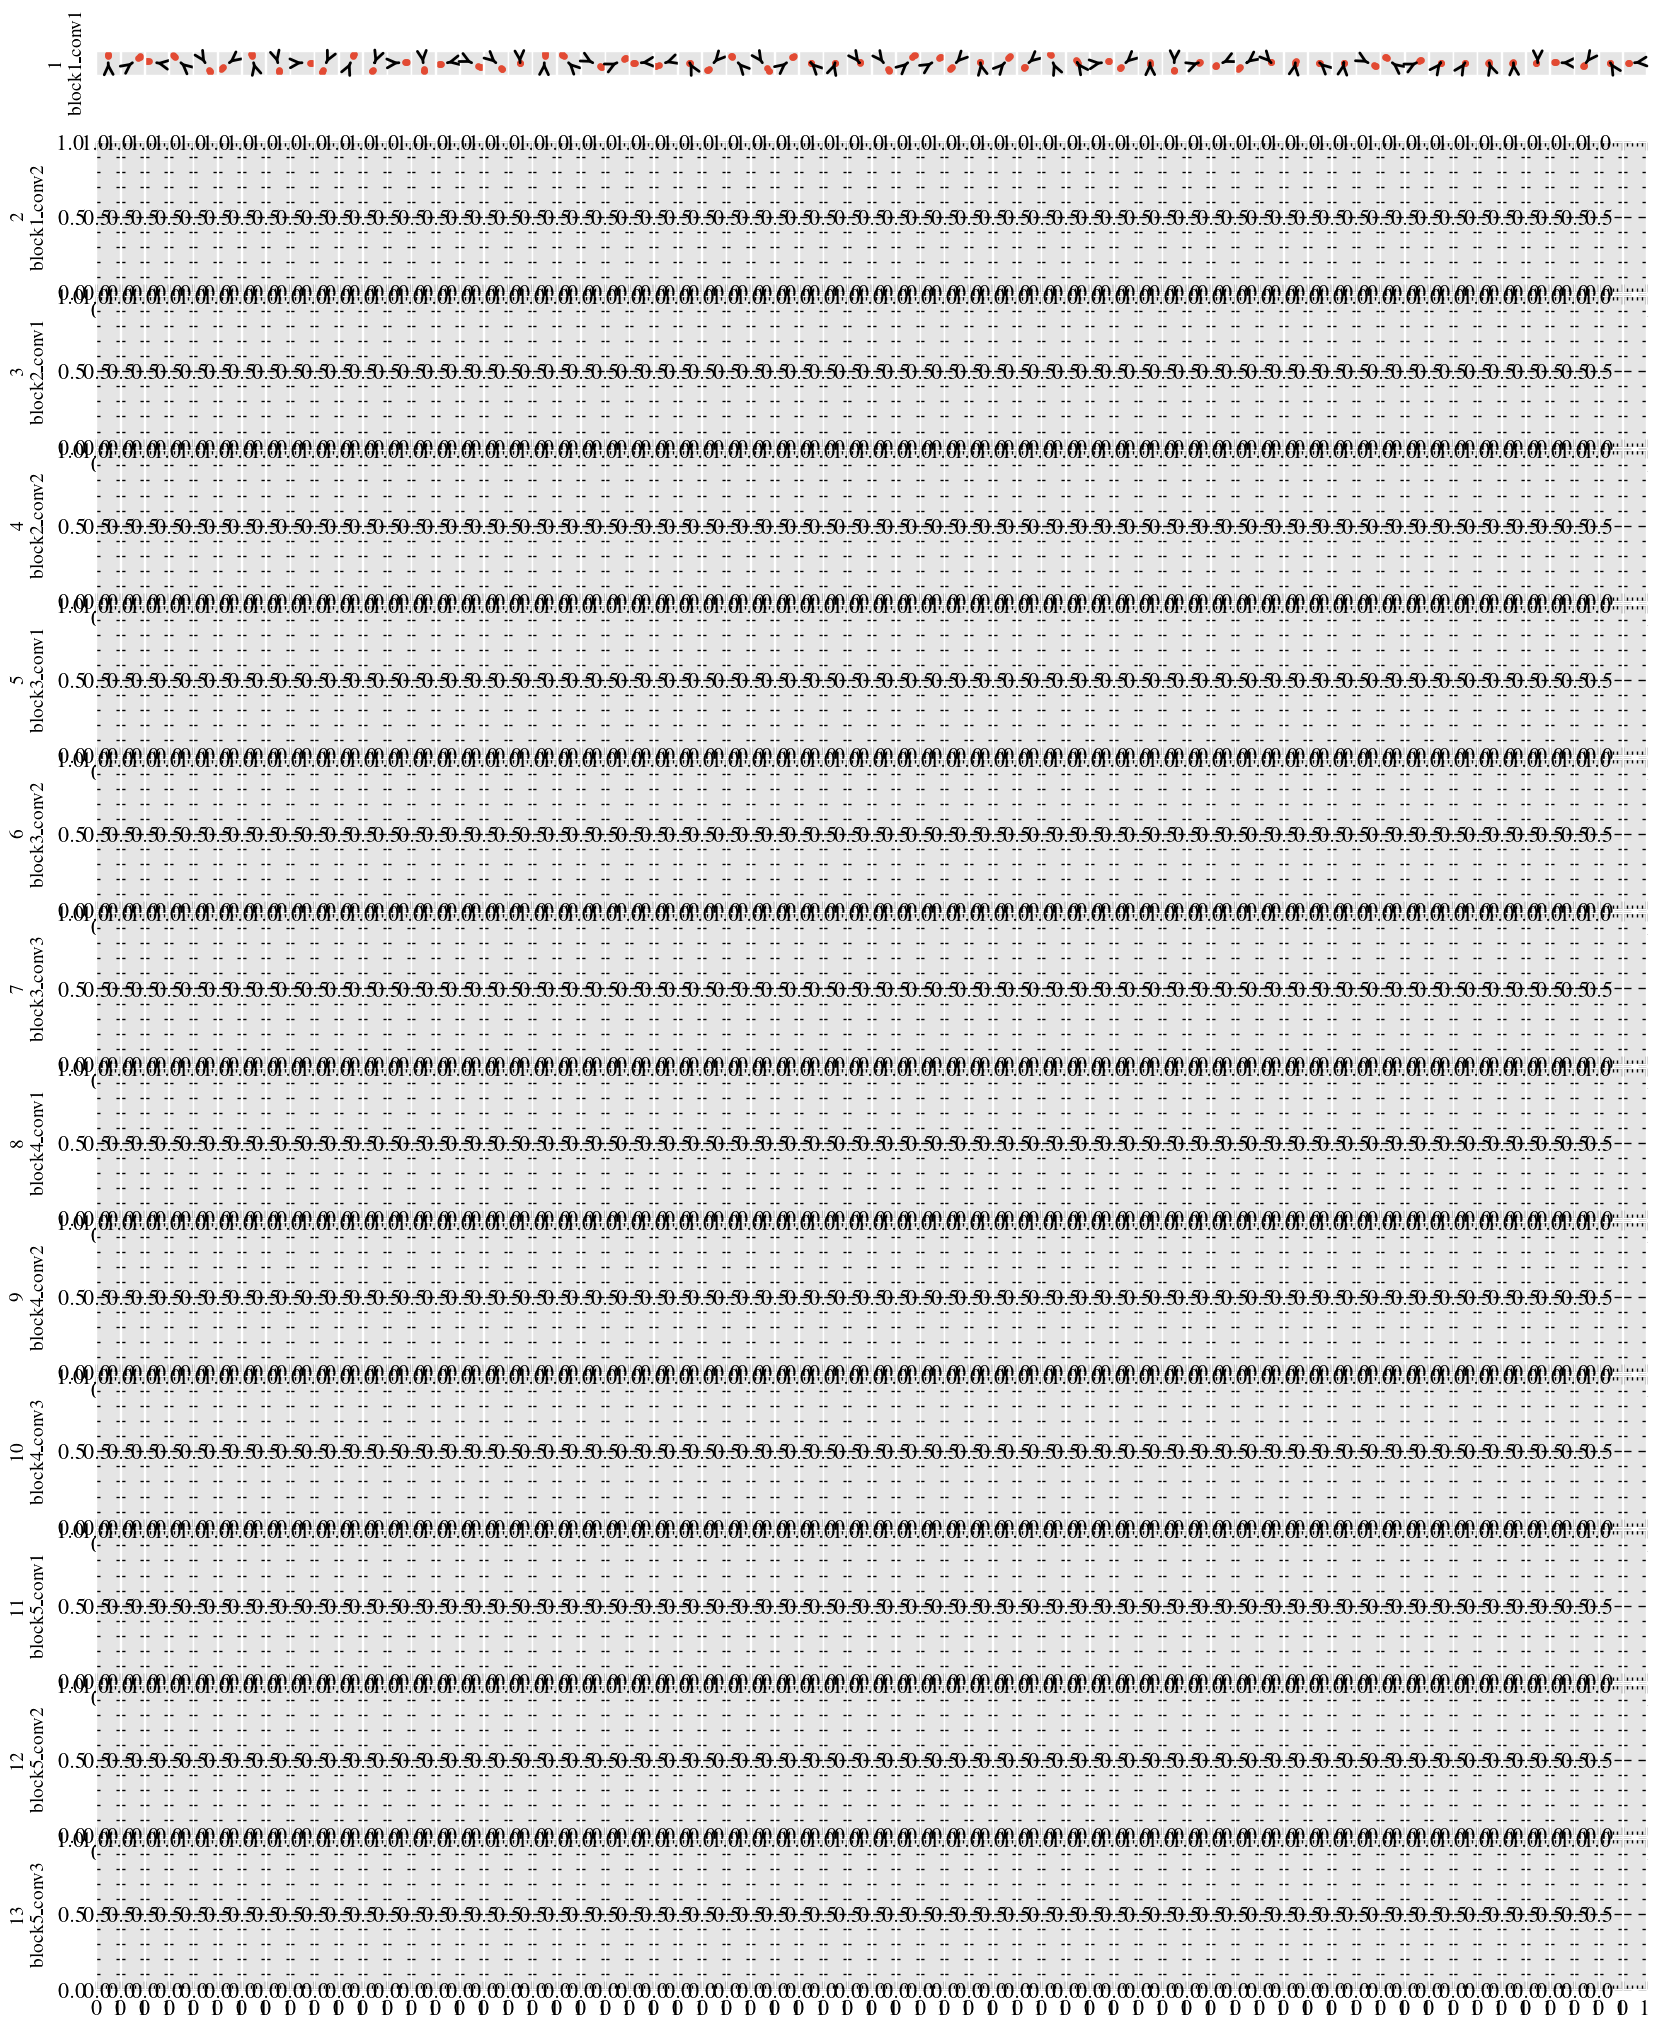

In [19]:

#plt.style.use(['ggplot'])
plt.rcParams.update({'figure.dpi': '200'})

plt.rcParams["axes.facecolor"] = "E5E5E5"
plt.rcParams["axes.edgecolor"] = "white"
conv_layers = []
for l in model.layers:
    if 'conv2d' in str(type(l)).lower():
        if l.kernel_size == (3,3):
            conv_layers.append(l)
e_beta = []
beta = []
min_beta = []
max_beta = []

fig= plt.figure(figsize = (10,13))
fig.clf()
#fig.tight_layout()
gs1 = gridspec.GridSpec(len(conv_layers), 64)
gs1.update(wspace=0.025, hspace=0.025) # set the spacing between axes. 
ax = [fig.add_subplot(ss) for ss in gs1]
ax = np.reshape(ax, (len(conv_layers), 64))
#fig, ax = plt.subplots(gs1 , sharex=False, sharey=False)



#fig.set_tight_layout(True)
for l_num, l in enumerate(conv_layers[0:1]):
    print(f" ============ LAYER {l_num} ==================")
    top10F=topKfilters(model, l_num, k=100)
    filters = get_filter(model, l_num)[:,:,:, top10F]
    print(top10F)
    filters = filters #/ np.sqrt(reduce_variance(filters, axis=None))
    theta = getSobelTF(filters)
    print(filters.shape)
    _, a = getSymAntiSymTF(filters)
    a_mag = reduce_euclidean_norm(a, axis=[0,1])
    mag = reduce_euclidean_norm(filters, axis=[0,1])

    #find lims :

    for i in range(64):
        
        x =a_mag[:,i]*np.cos((theta[:,i]))
        y = a_mag[:,i]*np.sin((theta[:,i]))
        lim_x = np.max(np.abs(x))
        lim_y = np.max(np.abs(y))
        lim = np.max([lim_x, lim_y])
        lim =np.max(np.abs(mag[:, i]))    
        lim*= 1.1

        cov = np.cov([x,y])
        e_val, e_vec = np.linalg.eig(cov)
        e_vec = e_vec[:, np.argmax(e_val)]
        e_val = np.max(e_val)
        if np.sign(e_vec[0]) != np.sign(x[np.argmax(np.abs(x))]):
            e_vec *= -1
        #print(e_val, e_vec)

        #ax[l_num, i] = fig.add_subplot(gs1[l_num,i])
        ax[l_num, i].set_xlim(-lim, lim)
        ax[l_num, i].set_ylim(-lim, lim)
        ax[l_num, i].scatter(x,y, s=2, color='#E24A33')
        ax[l_num, i].set_box_aspect(1)

        ax[l_num, i].set_xticks([])
        ax[l_num, i].set_yticks([])
        ax[l_num, i].set_aspect('equal')
        ax[l_num, i].collections[0].set_rasterized(True)

        #ax[l_num, i].arrow(0, 0, e_vec[0]/lim, e_vec[1]/lim, color="black", linestyle="--")
        #ax[l_num, i].arrow(0, 0, e_vec[0]*e_val*5, e_vec[1]*e_val*5, color="black", linestyle="--")
        ax[l_num, i].annotate("", xy=(e_vec[0]*e_val, e_vec[1]*e_val), xytext=(0, 0), 
                    arrowprops=dict(arrowstyle="->",  color='black', lw=None))
        #ax[l_num, i].set_title(f"{c:.2f}, {s:.2f}")
for i in range(len(conv_layers)):
    ax[i, 0].set_ylabel(f"{i+1}\n{conv_layers[i].name}", fontsize=7) 

#fig.subplots_adjust(left=None, bottom=None, right=0.005, top=0.005)




In [6]:
top10F=topKfilters(model, 0, k=100)[:10]
filters = get_filter(model, 0)[:,:,:, top10F]
filters = filters / reduce_variance(filters, axis=(0,1,2))

In [7]:
reduce_variance(filters, axis=None)

<tf.Tensor: shape=(), dtype=float32, numpy=10.594935>

In [8]:
##fig.subplots_adjust(wspace=0.025, hspace=0.025)
#plt.show()

In [9]:
#fig.savefig('figures/vgg16_bipol_with_gauge_constraint.pdf', dpi=300)
#plt.show()